In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020522,2025-12-17T00:00:00,Detroit Red Wings,New York Islanders,0.5460,0.4406,0.7686,3,2,True,False,True
1,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          557      0.5242 0.2537   0.7009 0.5211   0.5224
Totals (Over/Under)  557      0.4704 0.2500   0.6931 0.5143   0.5242
Asian Handicap       557      0.7397 0.1946   0.5789 0.5416   0.7379


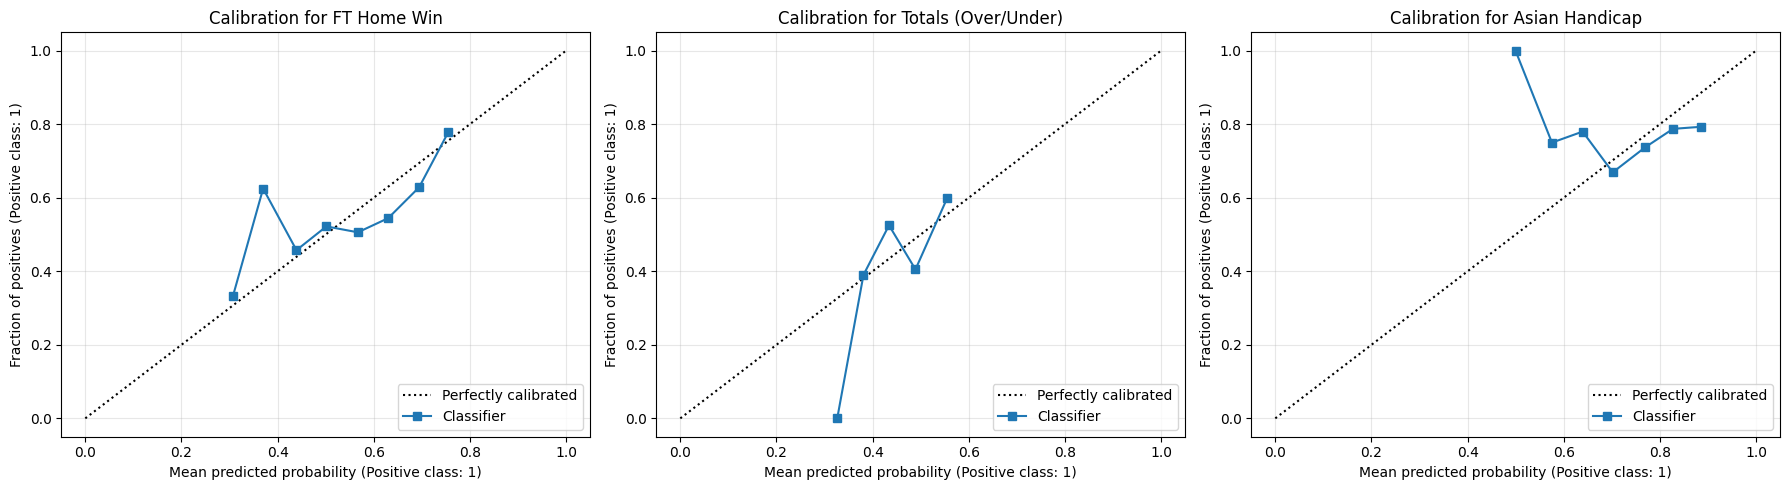

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=15)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          417      0.5228 0.2515   0.6959 0.5341   0.5228
Totals (Over/Under)  417      0.4700 0.2499   0.6928 0.5205   0.5132
Asian Handicap       417      0.7338 0.1980   0.5855 0.5385   0.7314


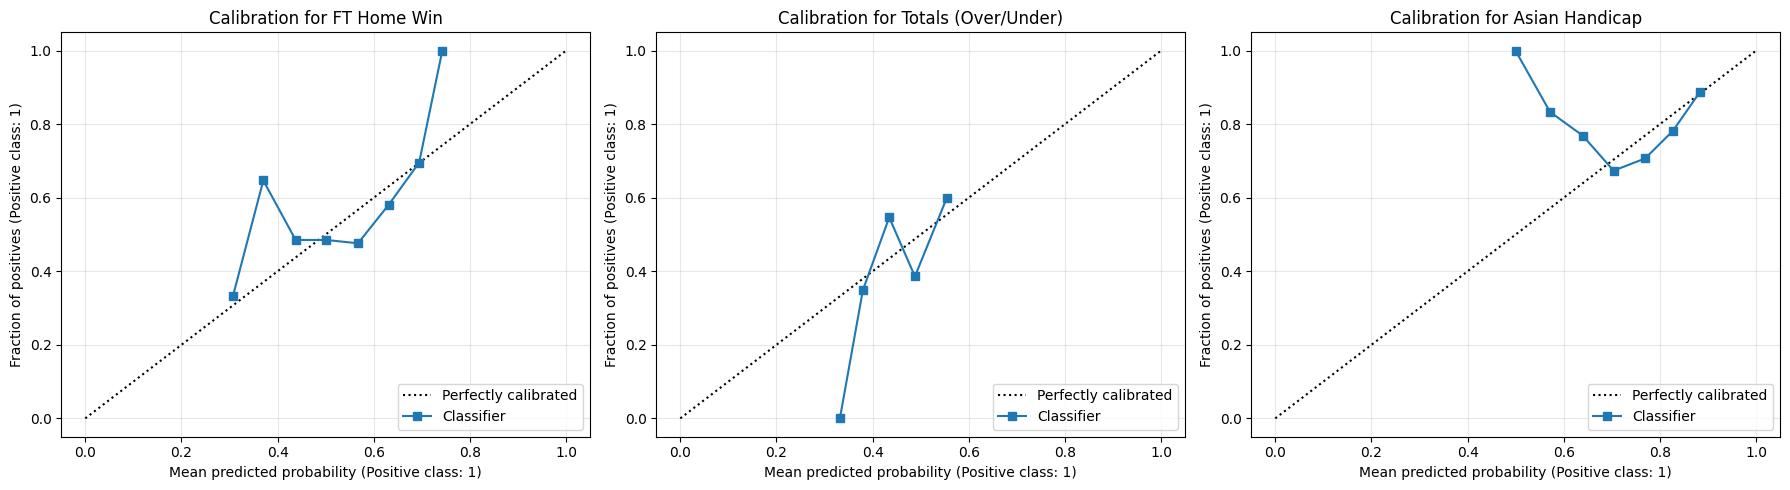

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=15)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500338,2025-12-06T00:00:00,Boston Celtics,Los Angeles Lakers,0.8098,0.7417,0.9232,126,105,True,True,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          273      0.5458 0.2317   0.6578 0.6618   0.6154
Totals (Over/Under)  273      0.5971 0.2455   0.6892 0.6156   0.5934
Asian Handicap       273      0.7399 0.1800   0.5362 0.6844   0.7253


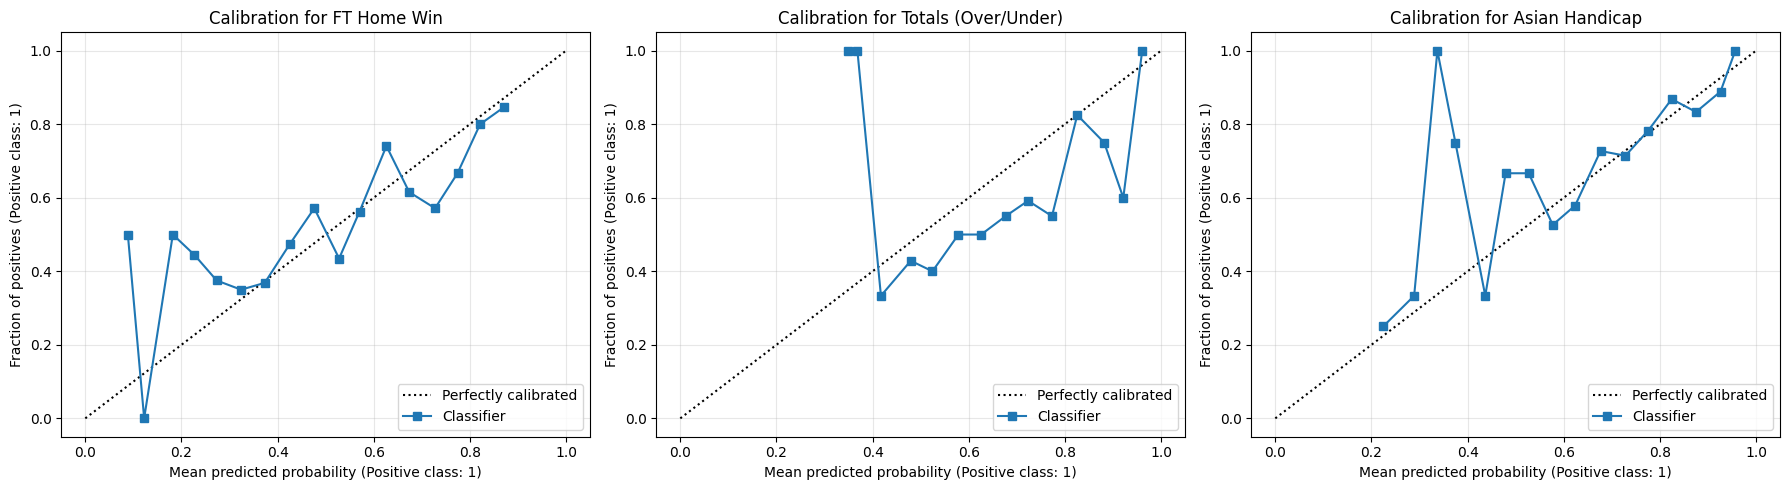

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=20)